In [90]:
from torch.utils.data import Dataset
from pathlib import Path
from typing import Any, Tuple
from typing import Callable
from typing import Dict
from typing import Iterable
from typing import List
from typing import Mapping
from typing import Optional
from typing import Union
import numpy as np
import pandas as pd
from loguru import logger
import lmdb
from safetensors.numpy import load as safetensor_load
import torch
import torch.nn.functional as F
from torch import nn
from functools import partial

In [234]:
label_to_idx = {
    'Arable land': 0,
    'Broad-leaved forest': 1,
    'Mixed forest': 2,
    'Pastures': 3,
    'Inland waters': 4,
    'Coniferous forest': 5,
    'Complex cultivation patterns': 6,
    'Land principally occupied by agriculture, with significant areas of natural vegetation': 7,
    'Urban fabric': 8,
    'Industrial or commercial units': 9,
    'Inland wetlands': 10,
    'Transitional woodland, shrub': 11,
    'Natural grassland and sparsely vegetated areas': 12,
    'Moors, heathland and sclerophyllous vegetation': 13,
    'Marine waters': 14,
    'Coastal wetlands': 15,
    'Permanent crops': 16,
    'Beaches, dunes, sands': 17,
    'Agro-forestry areas': 18
}

In [2]:
from src.utils.utils import load_config

In [3]:
config_path = "src/config/config.yaml"
config_dataset = load_config(config_path)

In [4]:
paths= {
    'path_dataset_lmdb':config_dataset["datasets"]["lmdb"],
    'path_metadata_parquet':config_dataset["datasets"]["metadata_parquet"],
    'path_metadata_snow_cloud_parquet':config_dataset["datasets"]["metadata_snow_cloud_parquet"]
}

In [12]:
df_parquet = pd.read_parquet(config_dataset['datasets']['metadata_parquet'])

In [149]:
_s2_bandnames_10m_20m = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
_s2_bandnames = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]

def stack_and_interpolate(
    bands: Dict[str, np.ndarray],
    order: Optional[Iterable[str]] = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
    img_size: int = 120,
    upsample_mode: str = "nearest",
) -> np.array:
    """
    Supports 2D input (as values in the dict) with "nearest", "bilinear" and "bicubic" interpolation

    Interpolates for all bands have the same size.
    """

    def _interpolate(img_data):
        if not img_data.shape[-2:] == (img_size, img_size):
            return F.interpolate(
                torch.Tensor(np.float32(img_data)).unsqueeze(0).unsqueeze(0),
                (img_size, img_size),
                mode=upsample_mode,
                align_corners=True if upsample_mode in ["bilinear", "bicubic"] else None,
            ).squeeze()
        else:
            return torch.Tensor(np.float32(img_data))
        
    ## Order and strip if the bands are reduced.
    stripped_bands=[]
    for b in order:
        if b in bands.keys():
            stripped_bands.append(b)
        ## Order following the bands passed 
    return torch.stack([_interpolate(bands[x]) for x in stripped_bands])


class LDMBReader:
    def __init__(
        self,
        image_lmdb_file: Union[str, Path],
        metadata_file: Union[str, Path],
        metadata_snow_cloud_file: Optional[Union[str, Path]] = None,
        bands: Optional[Union[Iterable, str, int]] = None,
        process_bands_fn: Optional[Callable[[Dict[str, np.ndarray], List[str]], Any]] = None,
        logger_verbose = True
    ):
        if logger_verbose:
            logger.add('LMBDREADER.log')
        self.image_lmdb_file = image_lmdb_file
        self.env = None

        self.bands = bands if bands is not None else _s2_bandnames

        ## Open metadata
        self.metadata = pd.read_parquet(metadata_file)
        if metadata_snow_cloud_file is not None:
            metadata_snow_cloud = pd.read_parquet(metadata_snow_cloud_file)
            self.metadata = pd.concat([self.metadata, metadata_snow_cloud])
            logger.info("Merged metadata with snow/cloud metadata")

        ## Create a dict with patches and labels 
        self.lbls = {p: l for p, l in zip(self.metadata["patch_id"], self.metadata["labels"])}

        ## Labels and 
        logger.info(f"Loaded {len(self.lbls)} labels")

        ## set key - patches name 
        self.lbl_key_set = set(self.lbls.keys())

        ##Messages.info(f"Loaded {len(self.lbl_key_set)} keys")

        # set mean and std based on bands selected
        self.mean = None
        self.std = None

        self.process_bands_fn = process_bands_fn if process_bands_fn is not None else lambda x, y: x

        self._keys: Optional[set] = None
        self._S2_keys: Optional[set] = None

    def open_env(self):
        if self.env is None:
            logger.info("Opening LMDB environment ...")
            self.env = lmdb.open(
                str(self.image_lmdb_file),
                readonly=True,
                lock=False,
                meminit=False,
                readahead=True,
                map_size=8 * 1024**3,  # 8GB blocked for caching
                max_spare_txns=16,  # expected number of concurrent transactions (e.g. threads/workers)
            )

    def keys(self, update: bool = False):
        self.open_env()
        if self._keys is None or update:
            logger.info("(Re-)Reading keys ...")
            assert self.env is not None, "Environment not opened yet"
            with self.env.begin() as txn:
                self._keys = set(txn.cursor().iternext(values=False))
            self._keys = {x.decode() for x in self._keys}
        return self._keys

    # def S2_keys(self, update: bool = False):
    #     if self._S2_keys is None or update:
    #         logger.info("(Re-)Reading S2 keys ..")
    #         self._S2_keys = {key for key in self.keys(update) if key.startswith("S2")}
    #     return self._S2_keys
    
    def S2_keys_parquet(self, train_test:str=None):
        """
        Return the IDs keys. 
        """
        train_test = train_test.lower().strip()
        
        if train_test is not None:
            self.S2_keys = self.metadata.loc[self.metadata['split']==train_test]['patch_id']
            return self.S2_keys
        else:
            self.S2_keys = self.metadata['patch_id']
            return self.S2_keys

    def __bandorder__(self):
        return self.stripped_bands
    
    def __getitem__(self, key: str):
        # the key is the name of the S2v2 patch

        # open lmdb file if not opened yet
        self.open_env()
        img_data_dict: dict = {}

        assert self.env is not None, "Environment not opened yet"
        # read image data for S2v2
        with self.env.begin(write=False, buffers=True) as txn:
            byte_data = txn.get(key.encode())
        img_data_dict.update(safetensor_load(bytes(byte_data)))


        assert isinstance(self.bands, list), "Bands should be a list"
        img_data_dict = {k: v for k, v in img_data_dict.items() if k in self.bands}

        img_data = self.process_bands_fn(img_data_dict, self.bands)
        labels = self.lbls[key] if key in self.lbl_key_set else []


        return img_data, labels

In [235]:
class Dataset_BigEarthNet:
    def __init__(
        self,
        lmdb_reader,   # class
        strip_bands,
        img_size,
        upsample_mode,
        normalize,
        split_train_test,
        transform=None,
        return_patch_id=True,
        patch_ids = None,
        band_order = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]
    ):
        """
        Implements a Dataset submodule of pytorch. 

        Args:
        lmdb_reader: LMDBClass
            See LMDBReader class
        patch_ids: 
            The patch_ids. The way of selecting Train, Test and Val patches. 
        strip_bands: List. 
            Bands to be selected
        img_size: int.
            Size of the Image. It will apply a interpolation to the desired image size.
        upsample_mode: str Nearest, Bicubic, Biliear
            Method of interpolation
        band_order: List 
            Order of the bands presented at the BigEarthDataset. 
        normalize: bool
            If normalize the data or not.
        mean_dict: dict
            Dict with bands and mean values of each band
        std_dict: dict
            Dict with bands and std values of each band
        transform:
            If apply torch.transform on images
        return_patch_id: bool
            To return the patch Index of not
        """
        
        self.lmdb_reader = lmdb_reader
        self.patch_ids = patch_ids
        self.strip_bands = strip_bands
        self.img_size = img_size
        self.upsample_mode = upsample_mode
        self.normalize = normalize
        self.split_train_test = split_train_test
        self.transform = transform
        self.return_patch_id = return_patch_id
        
        # Get band order
        if band_order is None:
            self.band_order = lmdb_reader.__bandorder__()
        else:
            self.band_order = band_order

        if self.split_train_test is None:
                # Use all available S2 keys from the LMDB reader
                self.patch_ids = self.lmdb_reader.S2_keys_parquet()  # this is a Series with strings representing the tile name 
                self.patch_ids_idx = self.patch_ids.index  # index related to the Series
                logger.info(f"Using all {len(self.patch_ids)} S2 patches from LMDB")
        else:
            self.patch_ids = self.lmdb_reader.S2_keys_parquet(split_train_test)
            self.patch_ids_idx = self.patch_ids.index
            logger.info(f"Using the partition: {self.split_train_test} with len{len(self.patch_ids_idx)}")

    def __len__(self) -> int:
        return len(self.patch_ids)
    
    def __patch_id__(self, index:int) -> str:
        return self.patch_ids.iloc[index]
    
    def __series__patch_id__(self) -> pd.Series():
        return self.patch_ids
    
    def df_split_(self, col_split) -> pd.DataFrame():
        """
        A df containing the df with patch_ids and the split description 

        args:
        col_split: str
            The name of the column that contains the split description
        """
        cols = ["patch_id", col_split]
        return self.lmdb_reader.metadata[cols]
    
    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, Any], Tuple[torch.Tensor, Any, str]]:
        ## search for id on the Series
        patch_id = self.patch_ids.iloc[idx]

        try:
            # Get data from LMDB reader
            image_data, labels = self.lmdb_reader.__getitem__(patch_id)

            ## Convert labels
            [label_to_idx[label] for label in labels]
            
            # Stack and Interpolate
            img_tensor = stack_and_interpolate(
                bands=image_data,
                order=self.strip_bands,
                img_size=self.img_size,
                upsample_mode=self.upsample_mode
            )

            # Apply transforms if provided
            if self.transform is not None:
                img_tensor = self.transform(img_tensor)

            # Return data
            if self.return_patch_id:
                return img_tensor, labels, patch_id
            else:
                return img_tensor, labels
                
        except Exception as e:
            logger.error(f"Error loading patch {patch_id}: {str(e)}")
            raise

In [76]:
tryier.__getitem__('S2B_MSIL2A_20180525T094029_N9999_R036_T35VNK_31_19_reference_map')

({}, [])

In [57]:
band_order = ["B02","B03", "B04"]
band_means = torch.tensor([means['60_nearest'][band] for band in band_order], dtype=torch.float32)
          

In [58]:
band_means

tensor([438.3785, 614.0620, 588.4111])

In [151]:
tryier = LDMBReader(
    image_lmdb_file= config_dataset["datasets"]["lmdb"],
    metadata_file = config_dataset["datasets"]["metadata_parquet"],
    metadata_snow_cloud_file= config_dataset["datasets"]["metadata_snow_cloud_parquet"],
    bands= ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]
)

2025-08-08 12:37:26.781 | INFO     | __main__:__init__:58 - Merged metadata with snow/cloud metadata
2025-08-08 12:37:26.916 | INFO     | __main__:__init__:64 - Loaded 549488 labels


In [10]:
for i in image_data.keys():
    print(i,image_data[i].shape)

B04 (120, 120)
B07 (60, 60)
B8A (60, 60)
B08 (120, 120)
B09 (20, 20)
B11 (60, 60)
B12 (60, 60)
B01 (20, 20)
B05 (60, 60)
B06 (60, 60)
B03 (120, 120)
B02 (120, 120)


In [101]:
img_interp = stack_and_interpolate(
    bands= image_data,
    order = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
    img_size = 120,
    upsample_mode= 'bilinear'
)


In [102]:
img_interp

tensor([[[ 671.0000,  689.2017,  707.4034,  ...,  192.9160,  191.9580,
           191.0000],
         [ 645.7731,  664.7905,  683.8080,  ...,  192.1485,  190.9356,
           189.7227],
         [ 620.5462,  640.3795,  660.2126,  ...,  191.3810,  189.9132,
           188.4454],
         ...,
         [ 412.9160,  413.7143,  414.5126,  ...,  207.2986,  209.8090,
           212.3193],
         [ 411.9580,  412.7563,  413.5546,  ...,  206.9350,  209.5473,
           212.1597],
         [ 411.0000,  411.7983,  412.5966,  ...,  206.5714,  209.2857,
           212.0000]],

        [[ 537.0000,  543.0000,  567.0000,  ...,  189.0000,  192.0000,
           175.0000],
         [ 501.0000,  526.0000,  519.0000,  ...,  203.0000,  182.0000,
           180.0000],
         [ 501.0000,  504.0000,  504.0000,  ...,  188.0000,  182.0000,
           181.0000],
         ...,
         [ 446.0000,  416.0000,  448.0000,  ...,  222.0000,  231.0000,
           185.0000],
         [ 457.0000,  424.0000,  446.000

In [27]:
import matplotlib.pyplot as plt
def normalize(tensor):
    """Normalize each band to [0, 1] range."""
    tensor = tensor.clone()
    for i in range(tensor.shape[0]):
        band = tensor[i]
        min_val = band.min()
        max_val = band.max()
        if max_val > min_val:  # avoid division by zero
            tensor[i] = (band - min_val) / (max_val - min_val)
    return tensor


plt.imshow(normalize(img_interp[[3,2,1],:,:]).permute(1,2,0))
plt.title(labels)

NameError: name 'img_interp' is not defined

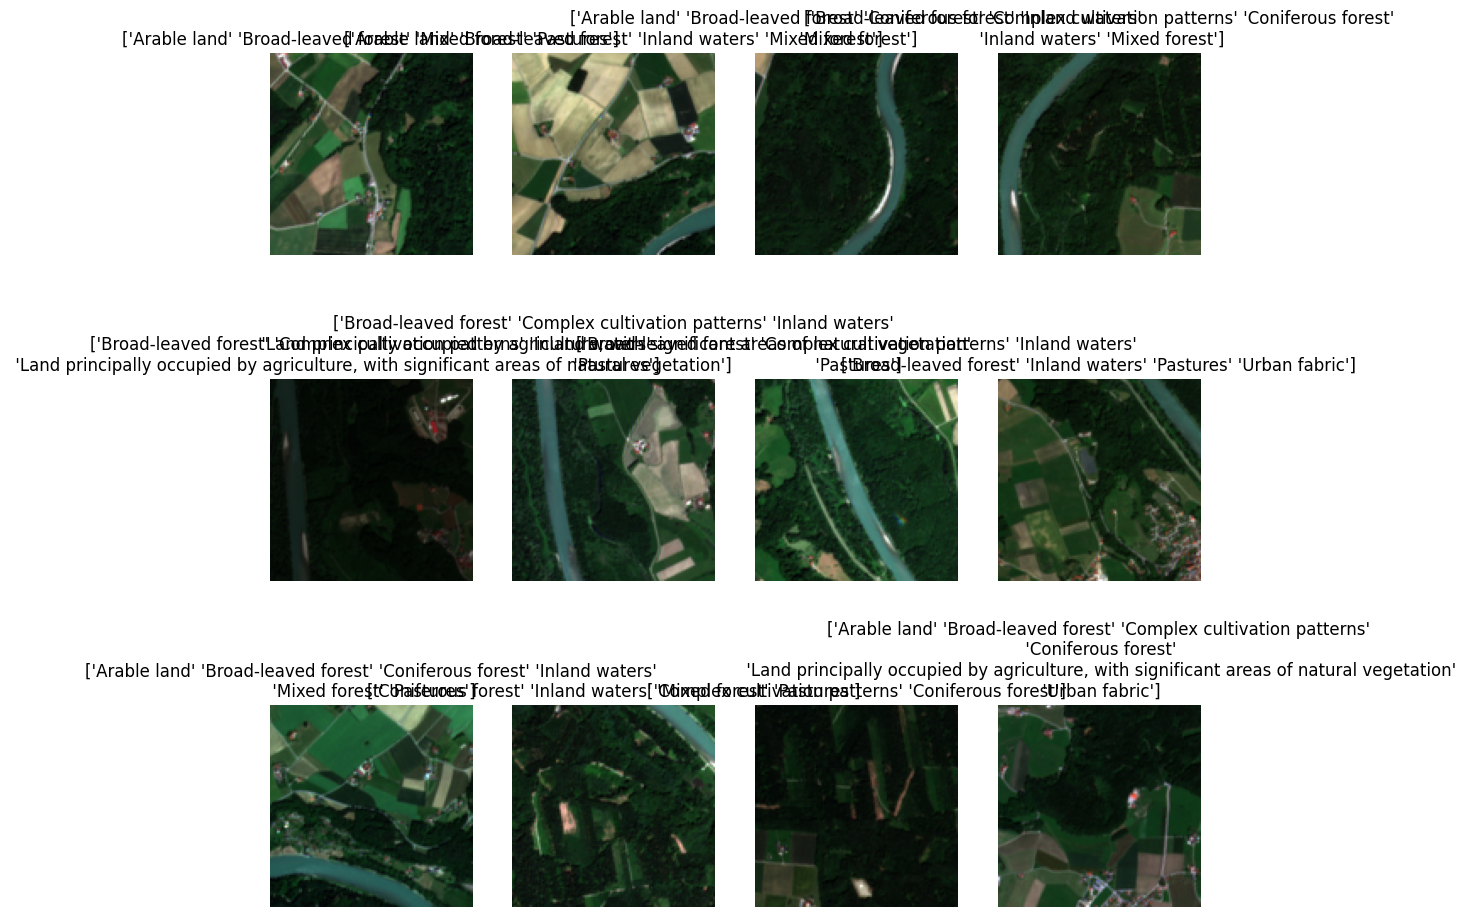

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for row in df_parquet[:12].iterrows():

    ## get image
    image_data, labels = tryier.__getitem__(row[1]['patch_id'])

    ## interpolate 
    img_interp = stack_and_interpolate(
    bands= image_data,
    order = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
    img_size = 120,
    upsample_mode= 'bilinear'
)   
    ##normalize and plot it 
    img_norm = normalize(img_interp[[3,2,1],:,:]).permute(1,2,0)

    fix_labels = labels.split
    # Plot the patch
    if row[0]<4:
        axes[0, row[0]].imshow(img_norm)
        axes[0, row[0]].set_title(labels)
        axes[0, row[0]].axis('off')  # Remove axis ticks and labels
    elif (row[0]>=4) & (row[0]<8):
        axes[1, (row[0]%4)].imshow(img_norm)
        axes[1, (row[0]%4)].set_title(labels)
        axes[1, (row[0]%4)].axis('off')  # Remove axis ticks and labels
    else:
        axes[2, (row[0]%4)].imshow(img_norm)
        axes[2, (row[0]%4)].set_title(labels)
        axes[2, (row[0]%4)].axis('off')  # Remove axis ticks and labels



    

In [33]:
labels

array(['Arable land', 'Broad-leaved forest',
       'Complex cultivation patterns', 'Coniferous forest',
       'Land principally occupied by agriculture, with significant areas of natural vegetation',
       'Urban fabric'], dtype=object)

## DATASET

In [180]:
datasetmod = Dataset_BigEarthNet(
    lmdb_reader= tryier,
    strip_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
    img_size= 120,
    upsample_mode='nearest',
    normalize =True,
    split_train_test= 'train'
)

2025-08-08 13:30:28.677 | INFO     | __main__:__init__:67 - Using the partition: train with len272544


In [181]:
datasetmod.strip_bands

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12']

In [153]:
datasetmod.__patch_id__(12)

'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_40_79'

In [154]:
datasetmod.__getitem__(0)

2025-08-08 12:37:38.741 | INFO     | __main__:open_env:82 - Opening LMDB environment ...


(tensor([[[ 720.,  720.,  720.,  ..., 1055., 1055., 1055.],
          [ 720.,  720.,  720.,  ..., 1055., 1055., 1055.],
          [ 720.,  720.,  720.,  ..., 1055., 1055., 1055.],
          ...,
          [ 430.,  430.,  430.,  ...,  640.,  640.,  640.],
          [ 430.,  430.,  430.,  ...,  640.,  640.,  640.],
          [ 430.,  430.,  430.,  ...,  640.,  640.,  640.]],
 
         [[ 521.,  692.,  781.,  ..., 1616., 1824., 1992.],
          [ 683.,  869.,  967.,  ..., 1526., 1754., 1900.],
          [ 967.,  993., 1009.,  ..., 1516., 1682., 1820.],
          ...,
          [ 485.,  469.,  443.,  ..., 1010., 1026.,  976.],
          [ 480.,  451.,  451.,  ...,  819.,  969.,  980.],
          [ 578.,  435.,  466.,  ...,  459.,  713.,  916.]],
 
         [[ 896.,  858.,  996.,  ..., 1562., 1760., 1986.],
          [1084., 1036., 1148.,  ..., 1498., 1716., 1908.],
          [1336., 1340., 1284.,  ..., 1480., 1802., 1894.],
          ...,
          [ 894.,  874.,  883.,  ..., 1356., 1368

In [133]:
datasetmod.df_split_("split")

patch_id       split
0      S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...        test
1      S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...        test
2      S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...        test
3      S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...        test
4      S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...        test
...                                                  ...         ...
69445  S2B_MSIL2A_20180522T093029_N9999_R136_T35VPJ_6...       train
69446  S2B_MSIL2A_20180522T093029_N9999_R136_T35VPJ_6...  validation
69447  S2B_MSIL2A_20180522T093029_N9999_R136_T35VPJ_6...  validation
69448  S2B_MSIL2A_20180522T093029_N9999_R136_T35VPJ_6...        test
69449  S2B_MSIL2A_20180522T093029_N9999_R136_T35VPJ_6...        test

[549488 rows x 2 columns]

## DATAMODULE

In [195]:
from torchvision import transforms
from torch.utils.data import DataLoader


def get_right_dict(s2_dict_mean,s2_dict_std, upsampling_method):       
        name_upsample = f"120_{upsampling_method}"
        mean_dict = s2_dict_mean[name_upsample]
        std_dict = s2_dict_std[name_upsample]
        return mean_dict,std_dict

class DataLoader_BigEarth():
    def __init__(self,
                 dataset,
                 batch_size,
                 num_workers,
                 pin_memory=True,
                 shuffle = False,
                 target_transform = None,
                mean_dict = None,
                std_dict = None,
                additional_transforms=None,
                auto_apply_transforms = True,
                 **dataloader_kwargs
                 ):
        """ 
         DataLoader for BigEarth dataset with normalization capabilities.
        
        Args:
            dataset: PyTorch dataset object
            batch_size (int): Number of samples per batch
            num_workers (int): Number of subprocesses for data loading
            pin_memory (bool): If True, tensors are copied into CUDA pinned memory
            shuffle (bool): If True, data is shuffled at every epoch
            target_transform: Transform to be applied to targets
            mean_dict (dict): Dictionary containing mean values for each band
            std_dict (dict): Dictionary containing std values for each band
            additional_transforms (list): List of additional torchvision transforms
            **dataloader_kwargs: Additional arguments for PyTorch DataLoader
        """

        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.shuffle = shuffle
        self.pin_memory = pin_memory
        self.target_transform = target_transform
        self.mean_dict = mean_dict
        self.std_dict = std_dict
        self.additional_transforms = additional_transforms or []
        self.dataloader_kwargs = dataloader_kwargs

        # Get the bands used when creating the dataset
        self.bands = self.dataset.strip_bands
        
        self.list_mean, self.list_std = [], []

        # Auto-apply transforms to dataset if requested
        if auto_apply_transforms and (mean_dict is not None or additional_transforms):
            transform_pipeline = self.transform()
            if hasattr(dataset, 'transform'):
                dataset.transform = transform_pipeline
            else:
                print("Warning: Dataset doesn't have 'transform' attribute. Transforms not applied.")
        

    def create_dataloader(self):
        dataloader = DataLoader(
            dataset = self.dataset,
            batch_size= self.batch_size,
            shuffle = self.shuffle,
            num_workers = self.num_workers,
            pin_memory = self.pin_memory,
            **self.dataloader_kwargs
        )
        return dataloader
    
    def get_list_means_std(self):
        """Extract mean and std values for each band from dictionaries."""
        if self.mean_dict is None or self.std_dict is None:
            raise ValueError("mean_dict and std_dict must be provided")
            
        for band in self.bands:
            self.list_mean.append(self.mean_dict[band])
            self.list_std.append(self.std_dict[band])
            
        assert len(self.list_mean) == len(self.list_std), "Mean and std lists must have same length"

    def apply_normalization(self):
            """Create normalization transform using band-specific mean and std values."""
            self.get_list_means_std()
            
            normalization_transform = transforms.Compose([
                transforms.Normalize(mean=self.list_mean, std=self.list_std)
            ])
            
            return normalization_transform

    def transform(self, include_normalization=True):
        """
        Create complete transform pipeline.
        
        Args:
            include_normalization (bool): Whether to include normalization in transform
            
        Returns:
            torchvision.transforms.Compose
        """
        transform_list = []
        
        # Add normalization if requested
        if include_normalization:
            norm_transform = self.apply_normalization()
            transform_list.extend(norm_transform.transforms)
        else:
            transform_list.append(transforms.ToTensor())
        
        # Add additional transforms
        transform_list.extend(self.additional_transforms)
        
        return transforms.Compose(transform_list)


    def __iter__(self):
        """Make the class iterable by delegating to the internal DataLoader."""
        if not hasattr(self, '_dataloader'):
            self._dataloader = self.create_dataloader()
        return iter(self._dataloader)
    
    def __len__(self):
        """Return the length of the dataset."""
        return len(self.dataset)



In [167]:
mean_dict, std_dict =get_right_dict(means_s2,stds_s2,'nearest')

In [196]:
additional_transforms = [
    transforms.Resize((224,224))
]

dataloader = DataLoader_BigEarth(
    dataset=datasetmod,
    batch_size=16,
    num_workers=4,
    mean_dict=mean_dict,
    std_dict=std_dict,
    additional_transforms=additional_transforms
)

In [173]:
for x,y in dataloader:
    print(x,y)

TypeError: 'DataLoader_BigEarth' object is not iterable

In [197]:
dataiter = iter(dataloader)

In [201]:
for x,y in dataloader:
    print(x,y)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 283, in collate_numpy_array_fn
    raise TypeError(default_collate_err_msg_format.format(elem.dtype))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object


In [198]:
def imshow(img):
  #  img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 283, in collate_numpy_array_fn
    raise TypeError(default_collate_err_msg_format.format(elem.dtype))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object


In [162]:
datasetmod.strip_bands

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12']

In [161]:
for band in datasetmod.strip_bands:
    print(means_s2['120_bicubic'][band])

360.637451171875
438.3720703125
614.0556640625
588.4096069335938
942.7472534179688
1769.8485107421875
2049.475830078125
2193.2919921875
2235.48681640625
2241.091064453125
1568.2117919921875
997.715087890625


In [ ]:
def create_split_dataloaders(
    lmdb_reader,
    batch_size,
    splits: List[str] = ['train', 'val', 'test'],
    split_column: str = 'split',
    batch_sizes: Optional[Union[int, Dict[str, int]]] = None,
    shuffle_splits: Optional[Union[bool, Dict[str, bool]]] = None,
    num_workers: int = 4,
    pin_memory: bool = True,
    img_size: int = 120,
    upsample_mode: str = 'bilinear',
    band_order: Optional[List[str]] = None,
    transform: Optional[Any] = None,
    target_transform: Optional[Any] = None,
    normalize: bool = True,
    means_dict: Optional[dict] = None,
    stds_dict: Optional[dict] = None,
    return_patch_id: bool = False,
    **dataloader_kwargs
) -> Dict[str, DataLoader]:
    """
    Create multiple DataLoaders for different splits
    
    Args:
        lmdb_reader: Your LMDBReader instance
        splits: List of split names to create loaders for
        split_column: Column name in metadata containing split info
        batch_sizes: Batch size(s) - int for all splits or dict for per-split
        shuffle_splits: Shuffle setting(s) - bool for all or dict for per-split
        **other args: Same as create_dataloader
    
    Returns:
        Dictionary mapping split names to DataLoaders
    """
    
    # Handle shuffle settings
    if shuffle_splits is None:
        shuffle_splits = {'train': True, 'val': False, 'test': False}
    elif isinstance(shuffle_splits, bool):
        shuffle_splits = {split: shuffle_splits for split in splits}
    
    dataloaders = {}
    
    for split in splits:
        # Get patch IDs for this split
        split_patch_ids = get_split_patch_ids(
            lmdb_reader.metadata, 
            split, 
            split_column
        )
        
        if len(split_patch_ids) == 0:
            logger.warning(f"No patches found for split '{split}'. Skipping.")
            continue
        
        logger.info(f"Creating DataLoader for '{split}' with {len(split_patch_ids)} patches")
        
        # Create DataLoader for this split
        dataloaders[split] = create_dataloader(
            lmdb_reader=lmdb_reader,
            batch_size=batch_sizes.get(split, 32),
            shuffle=shuffle_splits.get(split, False),
            num_workers=num_workers,
            pin_memory=pin_memory,
            patch_ids=split_patch_ids,
            img_size=img_size,
            upsample_mode=upsample_mode,
            band_order=band_order,
            transform=transform,
            target_transform=target_transform,
            normalize=normalize,
            means_dict=means_dict,
            stds_dict=stds_dict,
            return_patch_id=return_patch_id,
            **dataloader_kwargs
        )
    
    return dataloaders

In [41]:
print('train',len(df_parquet.loc[df_parquet['split']=='train']))
print('val',len(df_parquet.loc[df_parquet['split']=='validation']))
print('test',len(df_parquet.loc[df_parquet['split']=='test']))

train 237871
val 122342
test 119825


In [42]:
from torch.utils.data import Dataset, DataLoader

In [94]:
means_s2 = {
    "120_nearest": {
        "B01": 361.0767822265625,
        "B02": 438.3720703125,
        "B03": 614.0556640625,
        "B04": 588.4096069335938,
        "B05": 942.8433227539062,
        "B06": 1769.931640625,
        "B07": 2049.551513671875,
        "B08": 2193.2919921875,
        "B09": 2241.455322265625,
        "B11": 1568.226806640625,
        "B12": 997.7324829101562,
        "B8A": 2235.556640625,
        "VH": -19.352558135986328,
        "VV": -12.643863677978516,
    },
    "120_bilinear": {
        "B01": 360.64678955078125,
        "B02": 438.3720703125,
        "B03": 614.0556640625,
        "B04": 588.4096069335938,
        "B05": 942.7476806640625,
        "B06": 1769.8486328125,
        "B07": 2049.475830078125,
        "B08": 2193.2919921875,
        "B09": 2241.10595703125,
        "B11": 1568.2115478515625,
        "B12": 997.715087890625,
        "B8A": 2235.48681640625,
        "VH": -19.352558135986328,
        "VV": -12.643863677978516,
    },
    "120_bicubic": {
        "B01": 360.637451171875,
        "B02": 438.3720703125,
        "B03": 614.0556640625,
        "B04": 588.4096069335938,
        "B05": 942.7472534179688,
        "B06": 1769.8485107421875,
        "B07": 2049.475830078125,
        "B08": 2193.2919921875,
        "B09": 2241.091064453125,
        "B11": 1568.2117919921875,
        "B12": 997.715087890625,
        "B8A": 2235.48681640625,
        "VH": -19.352558135986328,
        "VV": -12.643863677978516,
    }
}

stds_s2 = {
        "120_nearest": {
        "B01": 575.0687255859375,
        "B02": 607.02685546875,
        "B03": 603.2968139648438,
        "B04": 684.56884765625,
        "B05": 738.4326782226562,
        "B06": 1100.4560546875,
        "B07": 1275.805419921875,
        "B08": 1369.3717041015625,
        "B09": 1316.393310546875,
        "B11": 1070.1612548828125,
        "B12": 813.5276489257812,
        "B8A": 1356.5440673828125,
        "VH": 5.590505599975586,
        "VV": 5.133493900299072,
    },
    "120_bilinear": {
        "B01": 563.1734008789062,
        "B02": 607.02685546875,
        "B03": 603.2968139648438,
        "B04": 684.56884765625,
        "B05": 727.5784301757812,
        "B06": 1087.4288330078125,
        "B07": 1261.4302978515625,
        "B08": 1369.3717041015625,
        "B09": 1294.35546875,
        "B11": 1063.9197998046875,
        "B12": 806.8846435546875,
        "B8A": 1342.490478515625,
        "VH": 5.590505599975586,
        "VV": 5.133493900299072,
    },
    "120_bicubic": {
        "B01": 572.3436889648438,
        "B02": 607.02685546875,
        "B03": 603.2968139648438,
        "B04": 684.56884765625,
        "B05": 738.3037719726562,
        "B06": 1100.46142578125,
        "B07": 1275.843505859375,
        "B08": 1369.3717041015625,
        "B09": 1313.6488037109375,
        "B11": 1070.8011474609375,
        "B12": 814.0936279296875,
        "B8A": 1356.754150390625,
        "VH": 5.590505599975586,
        "VV": 5.133493900299072,
    }
}

In [43]:
def band_combi_to_mean_std(bands: Iterable[str], interpolation: str = "120_nearest"):
    """
    Retrievs the mean and standard deviation for a given BigEarthNet
    BAND_COMBINATION_PREDEFINTIONS or list of bands.

    :param bands: a list of bandnames
    :param interpolation: the interpolation type to use. For available types see `means.keys()`

        :default: "120_nearest"


    :return: mean and standard deviation for the given combination in same order
    """
    bands = resolve_band_combi(bands)
    ben_channel_mean = np.array([means[interpolation][band] for band in bands])
    ben_channel_std = np.array([stds[interpolation][band] for band in bands])
    return ben_channel_mean, ben_channel_std

### MODIFIED

In [246]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
from typing import Union, Tuple, Any, Optional, Iterable, Dict
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def get_right_dict(s2_dict_mean, s2_dict_std, upsampling_method):       
    name_upsample = f"120_{upsampling_method}"
    mean_dict = s2_dict_mean[name_upsample]
    std_dict = s2_dict_std[name_upsample]
    return mean_dict, std_dict

def stack_and_interpolate(
    bands: Dict[str, np.ndarray],
    order: Optional[Iterable[str]] = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
    img_size: int = 120,
    upsample_mode: str = "nearest",
) -> torch.Tensor:  # Changed return type annotation
    """
    Supports 2D input (as values in the dict) with "nearest", "bilinear" and "bicubic" interpolation
    Interpolates for all bands have the same size.
    """
    def _interpolate(img_data):
        if not img_data.shape[-2:] == (img_size, img_size):
            return F.interpolate(
                torch.Tensor(np.float32(img_data)).unsqueeze(0).unsqueeze(0),
                (img_size, img_size),
                mode=upsample_mode,
                align_corners=True if upsample_mode in ["bilinear", "bicubic"] else None,
            ).squeeze()
        else:
            return torch.Tensor(np.float32(img_data))
        
    # Order and strip if the bands are reduced.
    stripped_bands = []
    for b in order:
        if b in bands.keys():
            stripped_bands.append(b)
    
    return torch.stack([_interpolate(bands[x]) for x in stripped_bands])


class Dataset_BigEarthNet(Dataset):  # Added Dataset inheritance
    def __init__(
        self,
        lmdb_reader,   # class
        strip_bands,
        img_size,
        upsample_mode,
        normalize,
        split_train_test,
        transform=None,
        return_patch_id=True,
        patch_ids=None,
        band_order=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
        label_to_idx=None
    ):
        """
        Implements a Dataset submodule of pytorch. 
        """
        
        self.lmdb_reader = lmdb_reader
        self.patch_ids = patch_ids
        self.strip_bands = strip_bands
        self.img_size = img_size
        self.upsample_mode = upsample_mode
        self.normalize = normalize
        self.split_train_test = split_train_test
        self.transform = transform
        self.return_patch_id = return_patch_id
        self.label_to_idx = label_to_idx or {}
        self.num_classes = len(self.label_to_idx) if self.label_to_idx else 19
        
        # Get band order
        if band_order is None:
            self.band_order = lmdb_reader.__bandorder__()
        else:
            self.band_order = band_order

        if self.split_train_test is None:
            # Use all available S2 keys from the LMDB reader
            self.patch_ids = self.lmdb_reader.S2_keys_parquet()
            self.patch_ids_idx = self.patch_ids.index
            print(f"Using all {len(self.patch_ids)} S2 patches from LMDB")  # Changed logger to print
        else:
            self.patch_ids = self.lmdb_reader.S2_keys_parquet(split_train_test)
            self.patch_ids_idx = self.patch_ids.index
            print(f"Using the partition: {self.split_train_test} with len {len(self.patch_ids_idx)}")  # Changed logger to print

    def __len__(self) -> int:
        return len(self.patch_ids)
    
    def __patch_id__(self, index: int) -> str:
        return self.patch_ids.iloc[index]
    
    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor, str]]:
        # Search for id on the Series
        patch_id = self.patch_ids.iloc[idx]

        try:
            # Get data from LMDB reader
            image_data, labels = self.lmdb_reader.__getitem__(patch_id)

            # Stack and Interpolate
            img_tensor = stack_and_interpolate(
                bands=image_data,
                order=self.strip_bands,
                img_size=self.img_size,
                upsample_mode=self.upsample_mode
            )

            # Apply transforms if provided
            if self.transform is not None:
                img_tensor = self.transform(img_tensor)

            # Convert labels to one-hot encoding
            one_hot_labels = torch.zeros(self.num_classes, dtype=torch.float32)
            if hasattr(labels, 'tolist'):
                labels = labels.tolist()
            
            for label in labels:
                if label in self.label_to_idx:
                    idx_label = self.label_to_idx[label]
                    one_hot_labels[idx_label] = 1.0

            # Return data
            if self.return_patch_id:
                return img_tensor, one_hot_labels, patch_id
            else:
                return img_tensor, one_hot_labels
                
        except Exception as e:
            print(f"Error loading patch {patch_id}: {str(e)}")
            raise


class DataLoader_BigEarth:
    def __init__(self,
                 dataset,
                 batch_size,
                 num_workers,
                 pin_memory=True,
                 shuffle=False,
                 target_transform=None,
                 mean_dict=None,
                 std_dict=None,
                 additional_transforms=None,
                 **dataloader_kwargs
                 ):
        """ 
         DataLoader for BigEarth dataset with normalization capabilities.
        """

        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.shuffle = shuffle
        self.pin_memory = pin_memory
        self.target_transform = target_transform
        self.mean_dict = mean_dict
        self.std_dict = std_dict
        self.additional_transforms = additional_transforms or []
        self.dataloader_kwargs = dataloader_kwargs

        # Get the bands used when creating the dataset
        self.bands = self.dataset.strip_bands
        
        # Apply transforms to dataset if provided
        if mean_dict is not None or additional_transforms:
            transform_pipeline = self.create_transform_pipeline()
            self.dataset.transform = transform_pipeline

    def create_transform_pipeline(self):
        """Create complete transform pipeline."""
        transform_list = []
        
        # Add normalization if mean and std are provided
        if self.mean_dict is not None and hasattr(self, 'std_dict') and self.std_dict is not None:
            list_mean = [self.mean_dict[band] for band in self.bands]
            list_std = [self.std_dict[band] for band in self.bands]
            transform_list.append(transforms.Normalize(mean=list_mean, std=list_std))
        
        # Add additional transforms
        transform_list.extend(self.additional_transforms)
        
        return transforms.Compose(transform_list) if transform_list else None

    def create_dataloader(self):
        dataloader = DataLoader(
            dataset=self.dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            **self.dataloader_kwargs
        )
        return dataloader
    
    def __iter__(self):
        """Make the class iterable by delegating to the internal DataLoader."""
        if not hasattr(self, '_dataloader'):
            self._dataloader = self.create_dataloader()
        return iter(self._dataloader)
    
    def __len__(self):
        """Return the length of the dataset."""
        return len(self.dataset)

In [247]:
datasetmod = Dataset_BigEarthNet(
    lmdb_reader= tryier,
    strip_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
    img_size= 120,
    upsample_mode='nearest',
    normalize =True,
    split_train_test= 'train',
    label_to_idx= label_to_idx
)

Using the partition: train with len 272544


In [248]:
additional_transforms = [
    transforms.Resize((224,224))
]

dataloader = DataLoader_BigEarth(
    dataset=datasetmod,
    batch_size=16,
    num_workers=4,
    mean_dict=mean_dict,
    std_dict=std_dict,
    additional_transforms=additional_transforms
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64288735..3.96723].


Batch shape: torch.Size([16, 12, 224, 224])
Labels shape: torch.Size([16, 19])


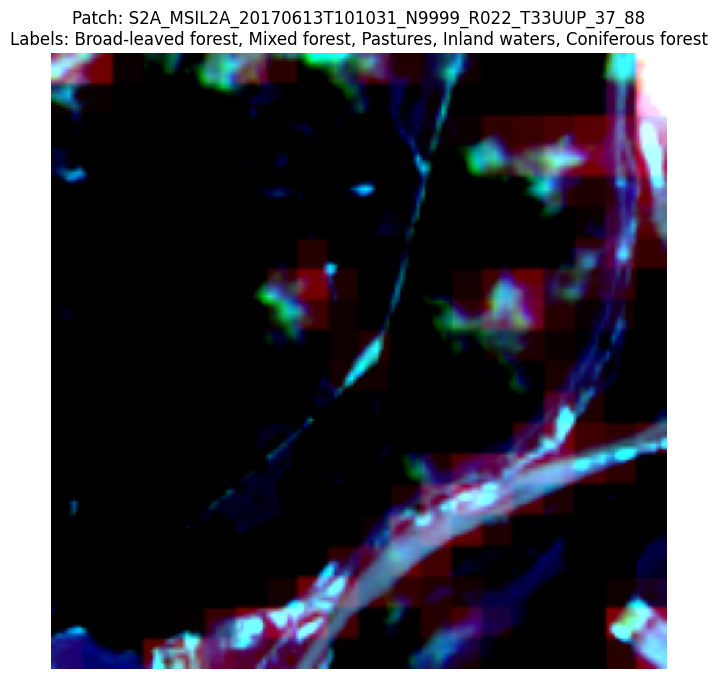

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66841525..11.511647].


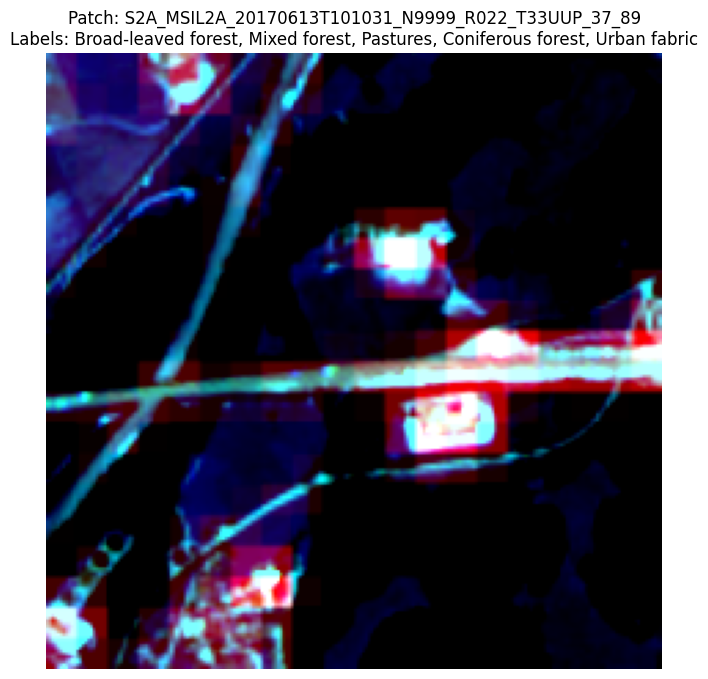

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6840467..4.0922966].


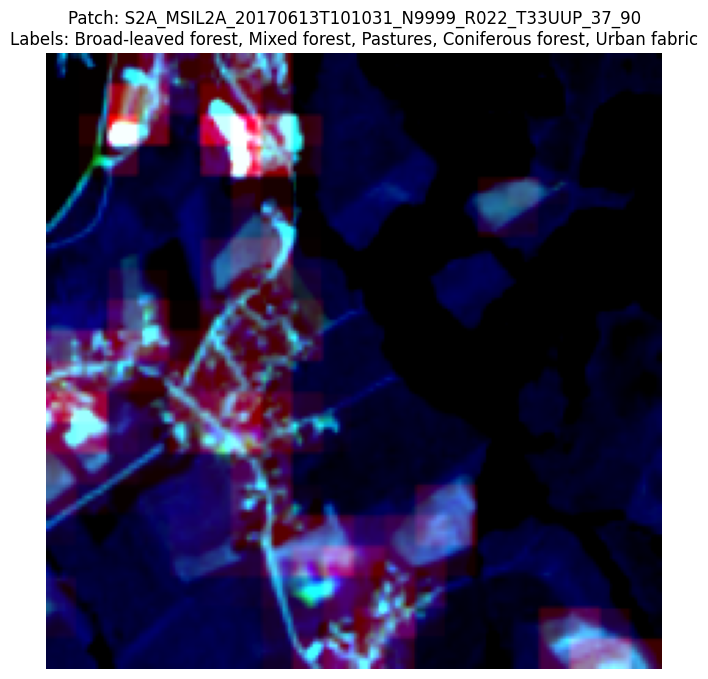

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6198288..7.055446].


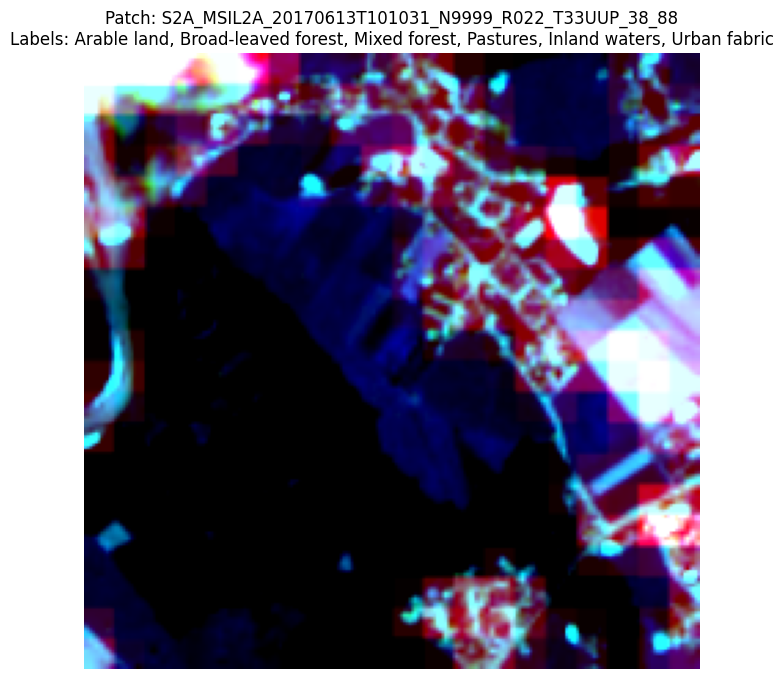

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6781755..4.377353].


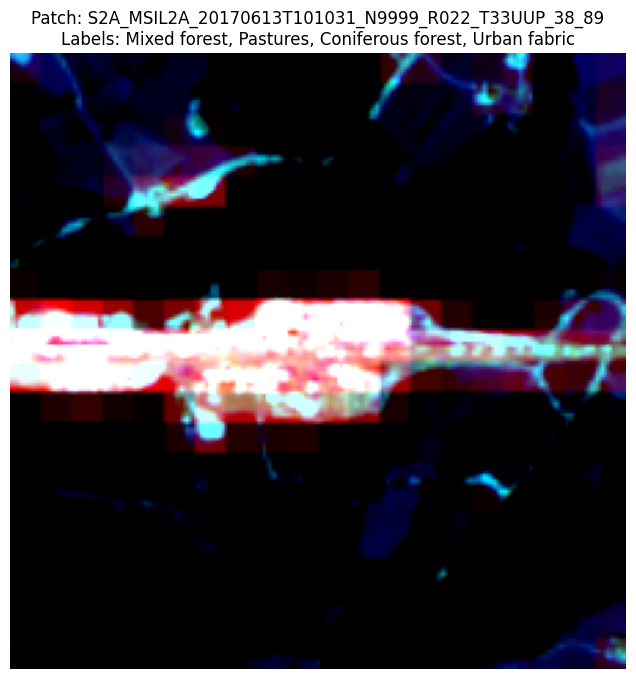

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7651202..2.5547915].


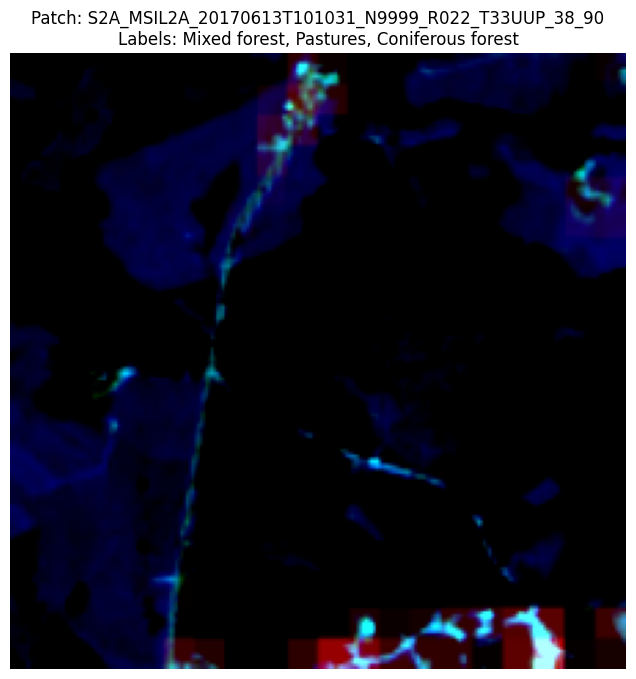

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47444296..4.2154245].


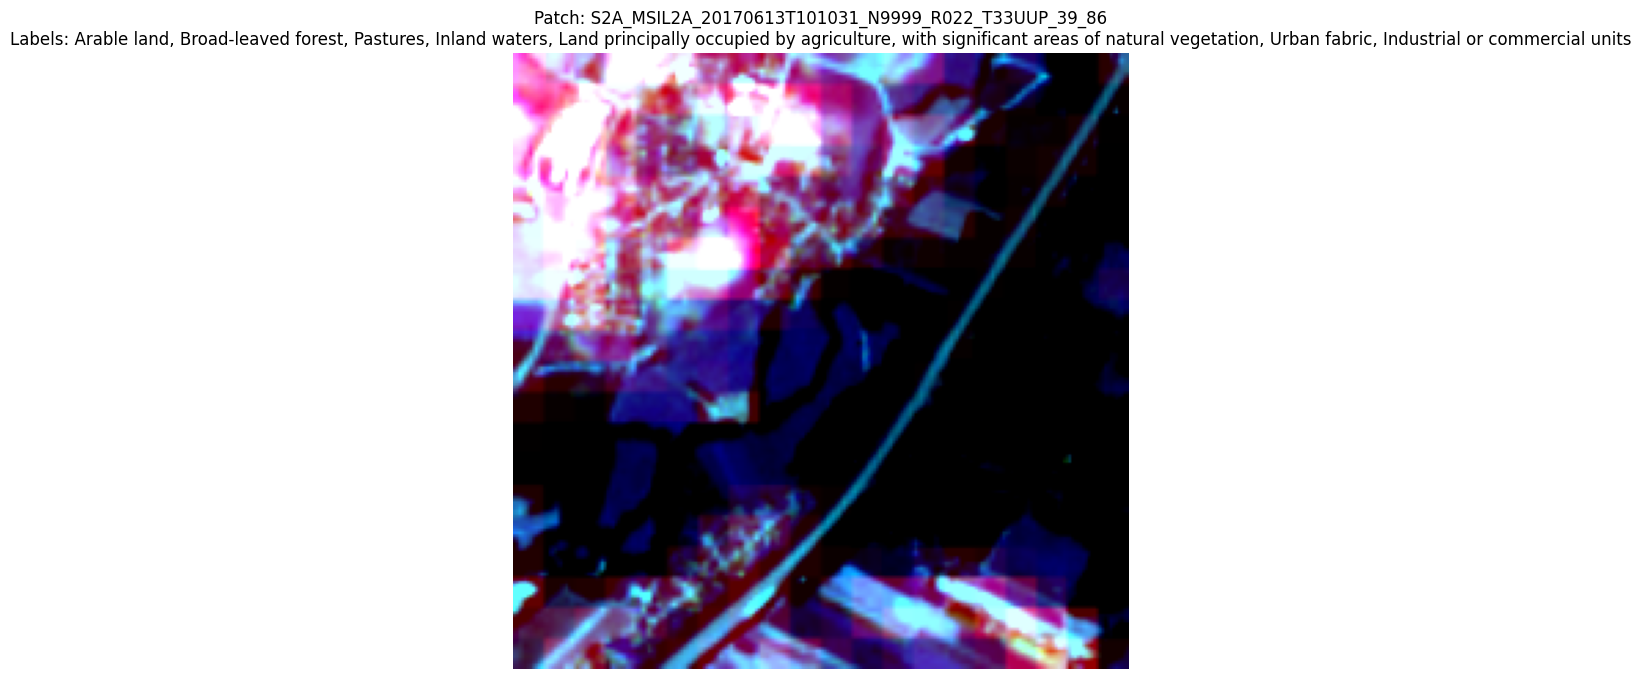

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4748506..4.7998962].


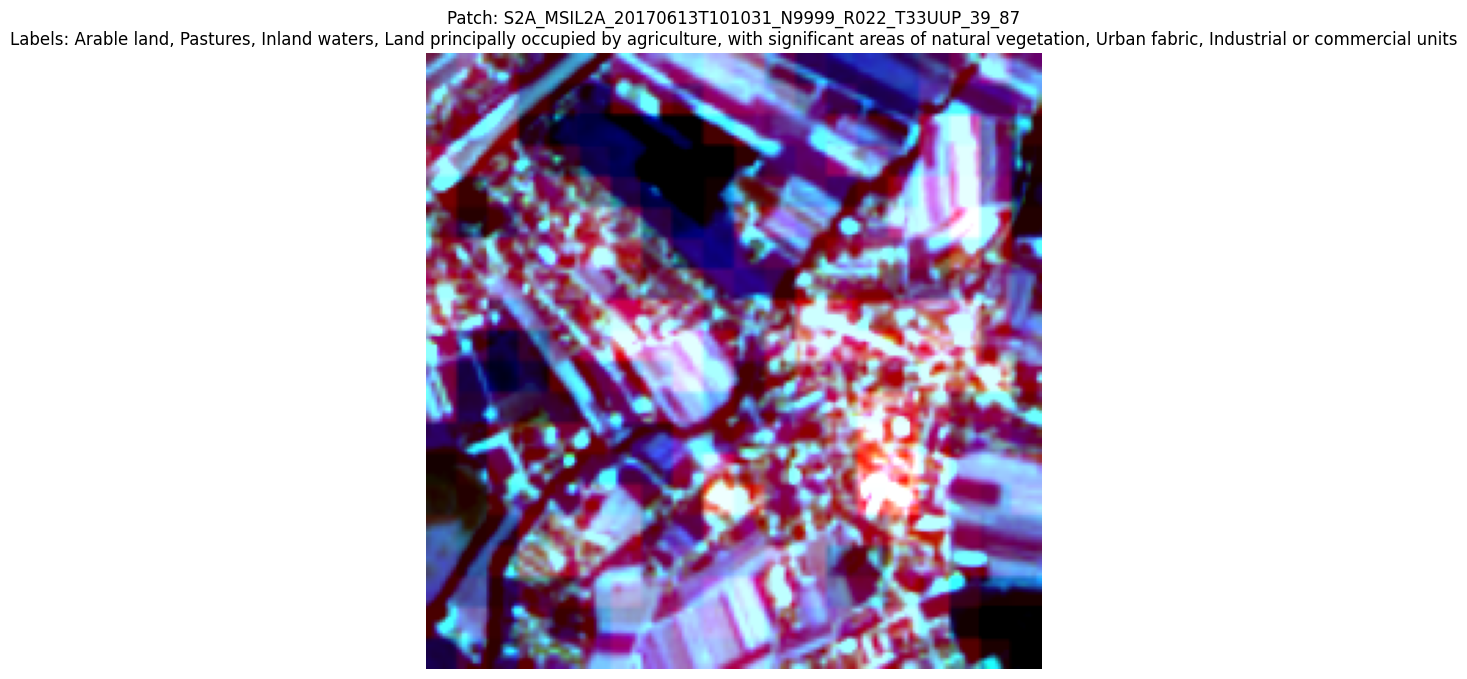

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5061684..3.703314].


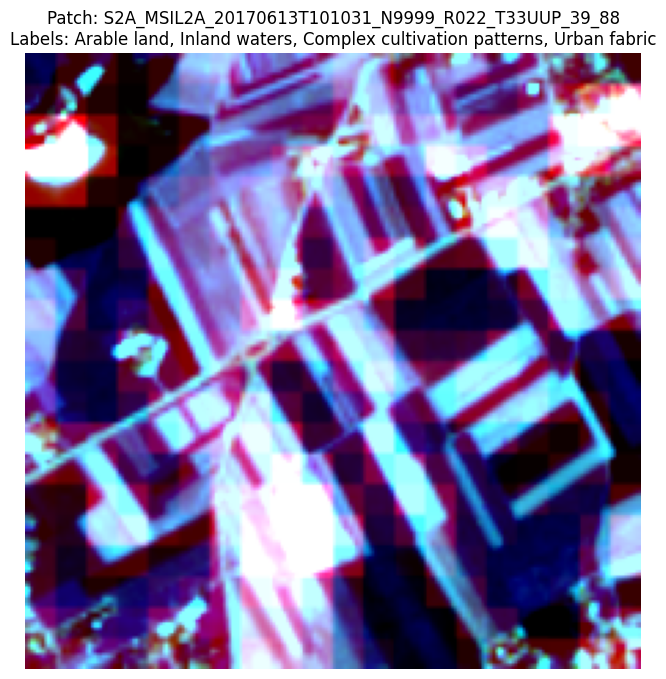

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61745805..2.1956923].


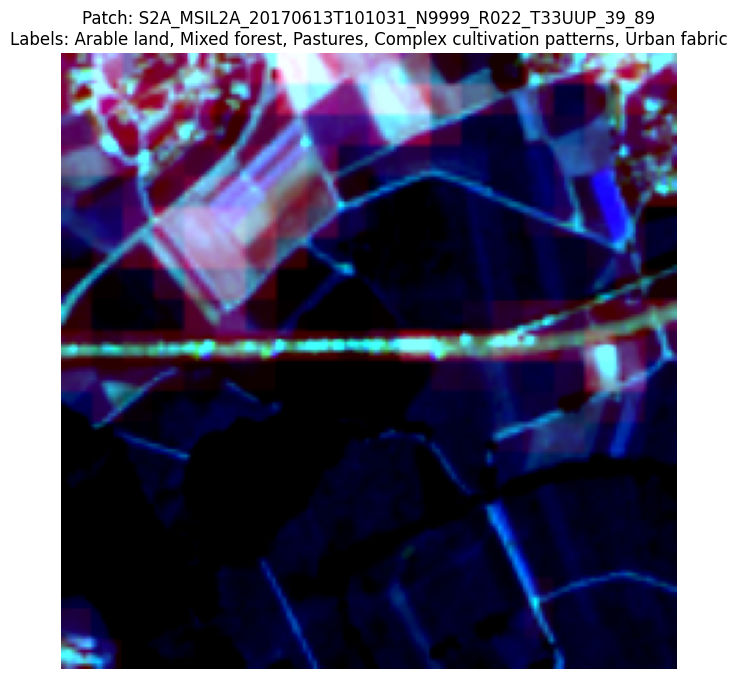

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69524455..1.4169872].


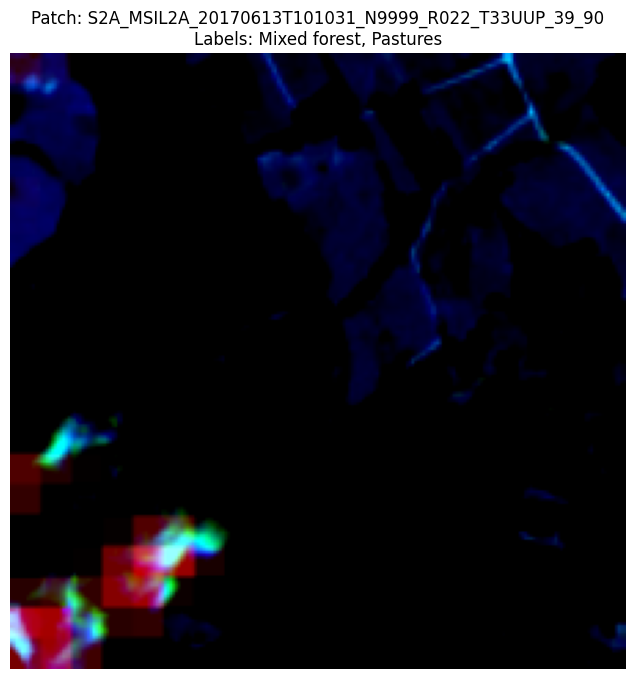

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61646616..1.4435959].


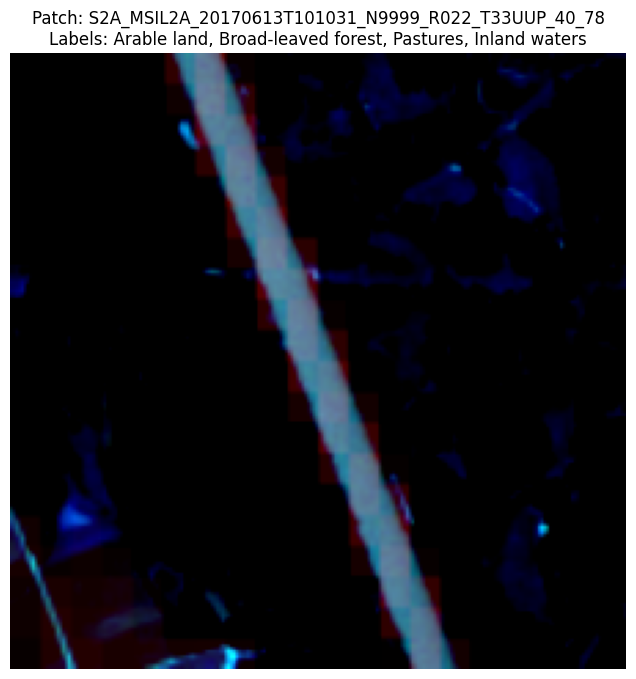

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7651202..11.511647].


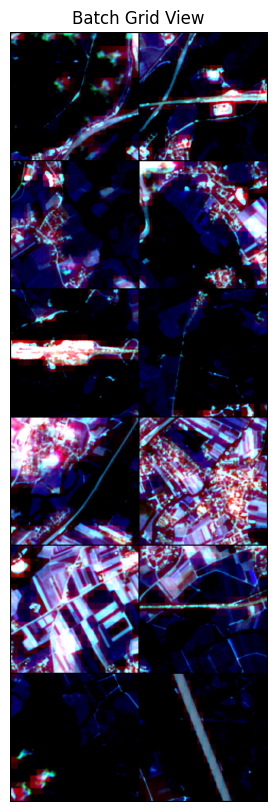

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
    self._run_once()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1949, in _run_once
    event_list = self._selector.select(timeout)
       

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def imshow(img, title=None):
    """Display image tensor."""
    # Unnormalize if needed
    # img = img / 2 + 0.5  # uncomment if your images are normalized
    
    npimg = img.numpy()
    plt.figure(figsize=(12, 8))
    
    # Handle single channel or RGB display
    if npimg.shape[0] == 1:
        plt.imshow(npimg[0], cmap='gray')
    elif npimg.shape[0] == 3:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        # For multispectral (select first 3 bands for RGB visualization)
        rgb_bands = npimg[:3]  # Take first 3 bands
        plt.imshow(np.transpose(rgb_bands, (1, 2, 0)))
    
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_batch_images(dataloader, num_images=4, idx_to_label=None):
    """Plot a few images from the dataloader with their labels."""
    
    # Get some random training images
    dataiter = iter(dataloader)
    images, labels, patch_ids = next(dataiter)
    
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Plot individual images
    for i in range(min(num_images, len(images))):
        img = images[i]
        label_vector = labels[i]
        patch_id = patch_ids[i]
        
        # Convert one-hot to label names
        active_indices = torch.where(label_vector == 1)[0].tolist()
        if idx_to_label:
            active_labels = [idx_to_label[idx] for idx in active_indices]
        else:
            active_labels = [f"Class_{idx}" for idx in active_indices]
        
        title = f"Patch: {patch_id}\nLabels: {', '.join(active_labels)}"
        imshow(img, title=title)
    
    # Also show grid of images
    plt.figure(figsize=(15, 10))
    grid_img = torchvision.utils.make_grid(images[:num_images], nrow=2, padding=2)
    npimg = grid_img.numpy()
    
    if npimg.shape[0] == 3:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        # For multispectral, use first 3 bands
        rgb_bands = npimg[:3]
        plt.imshow(np.transpose(rgb_bands, (1, 2, 0)))
    
    plt.title("Batch Grid View")
    plt.axis('off')
    plt.show()

# Create reverse mapping for label display
idx_to_label = {
    0: 'Arable land',
    1: 'Broad-leaved forest', 
    2: 'Mixed forest',
    3: 'Pastures',
    4: 'Inland waters',
    5: 'Coniferous forest',
    6: 'Complex cultivation patterns',
    7: 'Land principally occupied by agriculture, with significant areas of natural vegetation',
    8: 'Urban fabric',
    9: 'Industrial or commercial units',
    10: 'Inland wetlands',
    11: 'Transitional woodland, shrub',
    12: 'Natural grassland and sparsely vegetated areas',
    13: 'Moors, heathland and sclerophyllous vegetation',
    14: 'Marine waters',
    15: 'Coastal wetlands',
    16: 'Permanent crops',
    17: 'Beaches, dunes, sands',
    18: 'Agro-forestry areas'
}

# Usage:
plot_batch_images(dataloader, num_images=12, idx_to_label=idx_to_label)

In [ ]:
import torchvision
def imshow(img):
  #  img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader)
images, labels,_ = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

ERROR: Unexpected segmentation fault encountered in worker.
 

KeyboardInterrupt: 

Exception in thread Thread-2394 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^

In [206]:
next(iter(dataloader))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/bigearthnet/BigEarthNet-Models/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 283, in collate_numpy_array_fn
    raise TypeError(default_collate_err_msg_format.format(elem.dtype))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object
